# 1. Context and data upload

Data comes from [fr.openfoodfacts.org](https://fr.openfoodfacts.org/), and is kindly provided as a download-able [link](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip) by Openclassrooms.

First step is to download the file from the url provided.

In [1]:
# Download the zip file
!wget 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip'

--2023-09-11 06:43:51--  https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.120.80, 52.218.52.84, 52.92.16.16, ...
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.120.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88117814 (84M) [application/x-www-form-urlencoded]
Saving to: ‘fr.openfoodfacts.org.products.csv.zip’

fr.openfoodfacts.or 100%[===================>]  84.04M  44.1MB/s    in 1.9s    

2023-09-11 06:43:53 (44.1 MB/s) - ‘fr.openfoodfacts.org.products.csv.zip’ saved [88117814/88117814]



In [2]:
# Import the packages used

# Unzipping
from zipfile import ZipFile
# Work on data
import numpy as np
import pandas as pd
# Plot missing values
import missingno as msno
# Missing values imputation
from sklearn.impute import KNNImputer
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Then, within the folder, select the csv file and create the dataset

# Select the zip file:
with ZipFile("fr.openfoodfacts.org.products.csv.zip", 'r') as zObject:
  # Select the CSV file:
    with zObject.open("fr.openfoodfacts.org.products.csv") as myFile:
        # Read the file and create the dataset:
        init_data = pd.read_csv(myFile,
                                sep='\t',
                                encoding='utf-8')
zObject.close()

<ipython-input-3-80c7b8d75ad1>:8: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  init_data = pd.read_csv(myFile,


In [4]:
# These dtypes should be fixed for further analysis (warning from previous cell)
init_data.iloc[:, [0, 3, 5, 19, 20, 24, 25, 26, 27, 28, 35, 36, 37, 38, 39, 48
                   ]].sample(5, random_state=7)

,code,created_t,last_modified_t,manufacturing_places,manufacturing_places_tags,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,allergens,allergens_fr,traces,traces_tags,traces_fr,ingredients_from_palm_oil_tags
71658,70640011841,1489090944,1489090944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230205,3388690001123,1427633778,1427638829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191966,3068112300125,1430396595,1430400235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blé,NaN,"oeufs,lait,soja,graines de sésame,fruits à coque","en:eggs,en:milk,en:nuts,en:sesame-seeds,en:soy...","Œufs,Lait,Fruits à coque,Graines de sésame,Soja",NaN
153387,819893024112,1489074930,1489074930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51364,41500819389,1489056631,1489056631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Overview of the data and pre-selection of the columns

The main idea here is:
- determine which are the most determining variables for the Nutri-Score,
- knowing the value of some of these variables for a given product, is it possible to predict its Nutri-Score?

According to its [definition](https://en.wikipedia.org/wiki/Nutri-Score), the Nutri-Score is calculated as __total N score - total P score = Nutritional score__:
- Product ingredients negatively (__N__) affecting the Nutri-Score:
  - Energy density (kcal/100g, kcal/100ml for beverages),
  - Simple sugars (g/100g, g/100ml for beverages),
  - Saturated fats (g/100g, % for cooking fats),
  - Salt (mg/100g),
- Product ingredients positively (__P__) affecting the Nutri-Score:
  - Fruit, vegetables, nuts and legumes (%),
  - Fibre (g/100g),
  - Protein (g/100g),
  - Rapeseed, walnut and olive oil (unit TBD).

Score ranges from -15 to +40, the lower the value the better the quality.

These are the columns I keep at minima.

The variables are defined [here](https://world.openfoodfacts.org/data/data-fields.txt).

In [5]:
# Let's have a look at the shape first:
print("This dataset contains {} rows and {} columns".format(
    init_data.shape[0], init_data.shape[1]))

This dataset contains 320772 rows and 162 columns


In [8]:
# Display all the columns for analysis
pd.set_option('display.max_columns', init_data.shape[1]+1)
# Set the column width
pd.set_option('display.max_colwidth', 40)

init_data.sample(5, random_state=13)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
8007,11213056784,http://world-fr.openfoodfacts.org/pr...,usda-ndb-import,1489061206,2017-03-09T12:06:46Z,1489061206,2017-03-09T12:06:46Z,Peas & Carrots,NaN,NaN,NaN,NaN,Spartan,spartan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Green peas, water, carrots, sugar, s...",NaN,NaN,NaN,NaN,NaN,125 g (0.5 cup),NaN,0.0,[ green-peas -> en:green-peas ] [...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,a,NaN,NaN,"en:to-be-completed, en:nutrition-fac...","en:to-be-completed,en:nutrition-fact...","A compléter,Informations nutritionne...",NaN,NaN,NaN,NaN,201.0,NaN,0.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,8.00,4.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,2.4,NaN,NaN,NaN,0.6096,0.24,NaN,0.00072,NaN,NaN,NaN,NaN,0.0072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016,NaN,0.00086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN,NaN
75835,71429015739,http://world-fr.openfoodfacts.org/pr...,usda-ndb-import,1489067356,2017-03-09T13:49:16Z,1489067356,2017-03-09T13:49:16Z,"Crawfish, Shrimp & Crab Boil",NaN,NaN,NaN,NaN,Zatarain's,zatarain-s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Salt, dextrose, spices (including re...",NaN,NaN,NaN,NaN,NaN,1.2 g (0

In [10]:
# Let's round the numeric columns to 2 decimals
init_data = round(init_data, 2).copy()

## 2.1. Columns selection (a priori)

In [19]:
# Select the columns that interest me, a priori.
# The others can be added back for a more extensive analysis:
selected_cols = [
    'product_name', 'labels', 'labels_tags', 'labels_fr', 'countries_fr',
    'ingredients_text', 'additives', 'nutrition_grade_fr', 'pnns_groups_1',
    'pnns_groups_2', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
    'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g',
    'omega-6-fat_100g', 'omega-9-fat_100g', 'cholesterol_100g',
    'carbohydrates_100g', 'sugars_100g' ,'fiber_100g', 'proteins_100g',
    'salt_100g', 'sodium_100g', 'alcohol_100g', 'fruits-vegetables-nuts_100g',
    'nutrition-score-fr_100g']

In [20]:
# Filter the data
selected_df = init_data[selected_cols]
selected_df.shape

(320772, 28)

## 2.2. Select the rows sold, at least, in France
* Using the column 'countries_fr',
* These can be added back for further analysis

In [21]:
# First, fill the missing values of that column
selected_df['countries_fr'] = selected_df['countries_fr'].fillna('UNK')

<ipython-input-21-9f5ed23bd733>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['countries_fr'] = selected_df['countries_fr'].fillna('UNK')


In [22]:
# Let's filter the data for the rows where the Country contains "France"
french_df = selected_df[selected_df['countries_fr'].str.contains('France')]
french_df.shape

(98440, 28)

In [23]:
# We can now drop this column
french_df_drop = french_df.drop(columns='countries_fr')

## 2.3. Filter out the rows with no data for the Nutri Score
* If the prediction is possible, maybe add these rows back and predict the Nutri Score

In [24]:
# Let's see how many rows are empty for the Nutri Score
col_1 = 'nutrition_grade_fr'
col_2 = 'nutrition-score-fr_100g'

print(f"There are {french_df_drop[col_1].isna().sum()} empty rows for the \
column {col_1} and {french_df_drop[col_2].isna().sum()} empty rows for the \
column {col_2}")

There are 37025 empty rows for the column nutrition_grade_fr and 37025 empty rows for the column nutrition-score-fr_100g


This looks like these are the same rows, but let's confirm.

In [25]:
# Col_1 is empty while col_2 is not:
french_df_drop[french_df_drop[col_1].isna() & ~french_df_drop[col_2].isna()]

,product_name,labels,labels_tags,labels_fr,ingredients_text,additives,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,omega-9-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g


In [26]:
# Col_1 is not empty while col_2 is:
french_df_drop[~french_df_drop[col_1].isna() & french_df_drop[col_2].isna()]

,product_name,labels,labels_tags,labels_fr,ingredients_text,additives,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,omega-9-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g


In [27]:
# Select either to filter the data.
# That's a huge loss (~37%), but enough data remains:
french_nutri_df = french_df_drop[~french_df_drop[col_1].isna()]
french_nutri_df.shape

(61415, 27)

## 2.4. Work on the label(s)

In [28]:
# Let's investigate the labels
col_1 = 'labels'
col_2 = 'labels_tags'
col_3 = 'labels_fr'

french_nutri_df[[col_1, col_2, col_3]].sample(10, random_state=13)

,labels,labels_tags,labels_fr
245040,Produit en braille,en:in-braille,Produit en braille
245284,"Peu ou pas de sucre,Point Vert,Fabri...","en:low-or-no-sugar,en:green-dot,en:m...","Peu ou pas de sucre,Point Vert,Fabri..."
240949,NaN,NaN,NaN
239728,"Labels de distributeurs,Qualité Carr...","en:labels-of-distributors,en:carrefo...","Labels de distributeurs,Qualité Carr..."
313361,"Sans conservateurs,Non fabriqué à l'...","en:no-preservatives,fr:non-fabrique-...","Sans conservateurs,Non-fabrique-a-l-..."
193602,"Viande Française,Sans OGM,Viande Por...","en:no-gmos,fr:viande-francaise,fr:vi...","Sans OGM,Viande Française,Viande Por..."
195373,NaN,NaN,NaN
188266,"Sans bisphénol-A,Sans gluten","en:gluten-free,en:no-bisphenol-a","Sans gluten,Sans bisphénol-A"
194585,Fournisseur breveté de la cour de Be...,fr:fournisseur-brevete-de-la-cour-de...,Fournisseur-brevete-de-la-cour-de-be...
205284,"Sélection Intermarché,Point Vert","en:labels-of-distributors,en:green-d...","Labels de distributeurs,Point Vert,S..."


There seems to be some information in here. This can be used to extract whether a product is Bio, Organic, GMO, BPA-free, etc.

In [29]:
# I will not use them here, at least for now:
rmv_labels = french_nutri_df.drop(columns=[col_1, col_2, col_3])
rmv_labels.shape

(61415, 24)

## 2.5 Work on the ingredients and the additives

In [30]:
# Define the columns and get a sample
col_1 = 'ingredients_text'
col_2 = 'additives'

rmv_labels[[col_1, col_2]].sample(10, random_state=13)

,ingredients_text,additives
245040,NaN,NaN
245284,Jus d'ananas.,[ jus-d-ananas -> fr:jus-d-ananas ...
240949,"Lait entier 98%, lactose et protéine...",[ lait-entier-98 -> fr:lait-entier-...
239728,Riz long grain étuvé de qualité supé...,[ riz-long-grain-etuve-de-qualite-s...
313361,"Pommes de terre (96 %), assaisonneme...",[ pommes-de-terre -> fr:pommes-de-t...
193602,Filet de porc issu d'animaux nourris...,[ filet-de-porc-issu-d-animaux-nour...
195373,NaN,NaN
188266,"pomme 77,4%, banane 20,4%, sucre, an...",[ pomme-77 -> fr:pomme-77 ] [ pom...
194585,"Farine de blé, sucre, chocolat au la...",[ farine-de-ble -> fr:farine-de-ble...
205284,"Haricots verts extra-fins, eau, sel.",[ haricots-verts-extra-fins -> fr:h...


There seems to be some information in here. This can be used to extract whether a product contains milk, almonds, etc.

In [31]:
# I will not use them here, at least for now:
base_df = rmv_labels.drop(columns=[col_1, col_2])
base_df.shape

(61415, 22)

# 3. Data preparation (cleaning and completion)

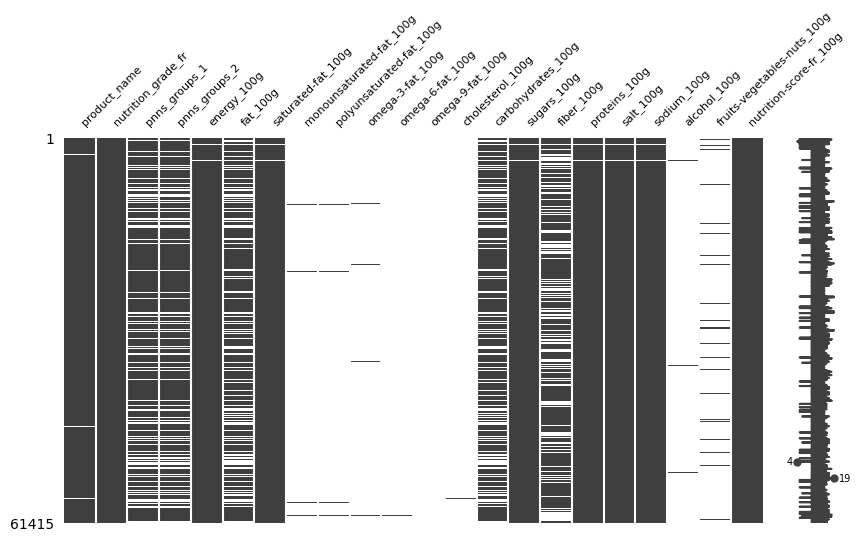

In [32]:
# Let's have an idea of the completion, visually
_ = msno.matrix(df=base_df, figsize=(10,5), fontsize=8)

Altough a different way of doing this would be to create a column encoding the missingness, or trying to impute values, I delete the following columns for being too empty (see cell below).

This is done visually (via the above plot), but this should be automated by selecting the rows with more/less (depending on the coding) missing values than a defined threshold.

In [33]:
# Define the list of column to drop:
empty_cols = ['monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
              'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g',
              'cholesterol_100g', 'alcohol_100g']

base_df_rmv = base_df.drop(columns=empty_cols)

In [34]:
# For the fruits-veg column, since I need it, I will create a new column to
# encode the missingness, and fill the missing values with 0

# First, create the new column
base_df_rmv['fruits-veg-missing'] = base_df_rmv[
    'fruits-vegetables-nuts_100g'].isna().astype('int64')

# Then, fill the missing values
base_df_rmv['fruits-vegetables-nuts_100g'] = base_df_rmv[
    'fruits-vegetables-nuts_100g'].fillna(0)

In [37]:
# Let's remove the duplicate rows (if any).

print(f'Rows before dedup: {base_df_rmv.shape[0]}')
# Ignore_index to reset the index:
base_df_rmv.drop_duplicates(inplace=True, ignore_index=True)
print(f'Rows after dedup: {base_df_rmv.shape[0]}')

Rows before dedup: 61415
Rows after dedup: 60495


## 3.1. Outliers and sanity checks

### 3.1.1. Quantities

In [39]:
# Define list of quantitative columns
quant_cols = ['energy_100g', 'fat_100g', 'saturated-fat_100g',
              'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
              'proteins_100g', 'salt_100g', 'sodium_100g',
              'fruits-vegetables-nuts_100g', 'nutrition-score-fr_100g',
              'fruits-veg-missing']

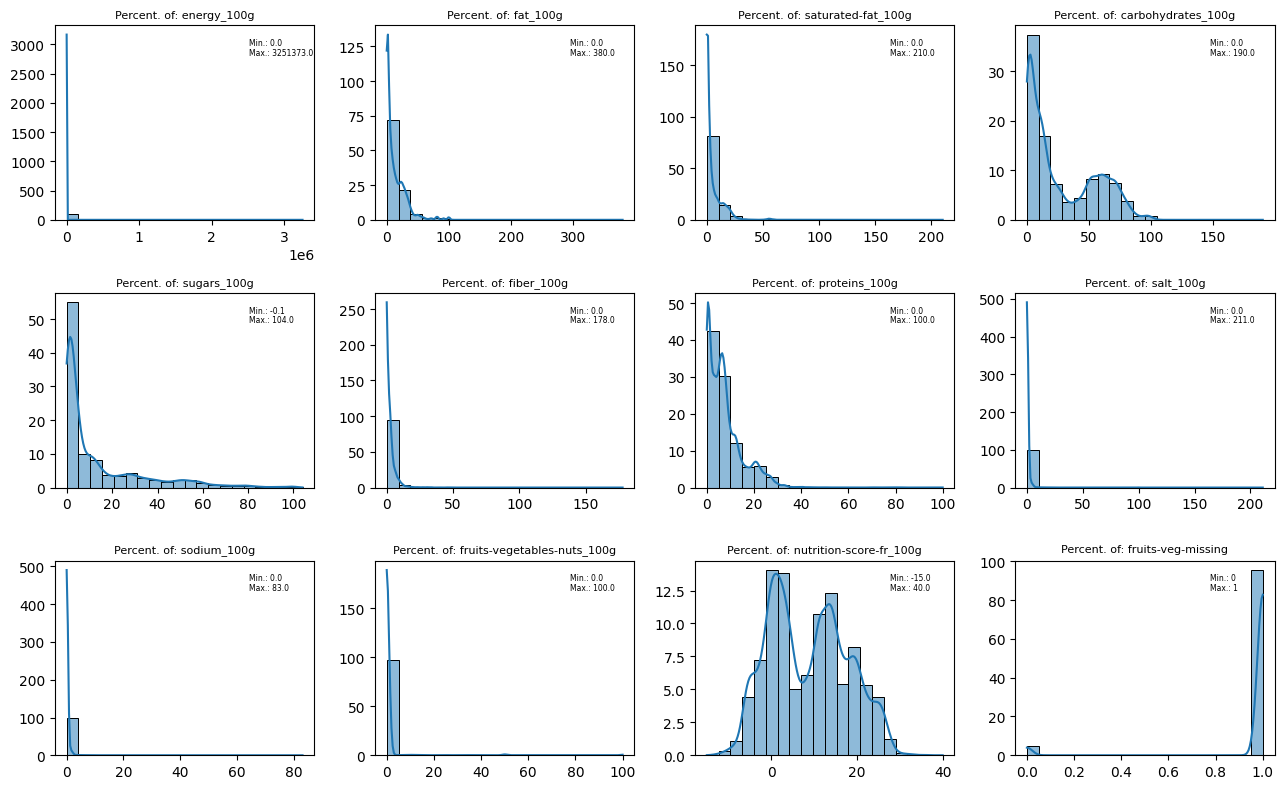

In [40]:
# Let's start by representing each variable with a histogram

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (13,8)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for each column
_, axs = plt.subplots(3, 4)
for i in range(len(quant_cols)):
  sns.histplot(base_df_rmv, x=quant_cols[i], stat='percent', bins=20, kde=True,
               ax=axs[i//4, i%4])
  # Remove x and y axis names
  axs[i//4, i%4].set(xlabel='', ylabel='')
  # Set the column name as title
  axs[i//4, i%4].set_title('Percent. of: {}'.format(quant_cols[i]), fontsize=8)
  # Add min and max within the subplots
  axs[i//4, i%4].text(0.75, 0.9,
                      'Min.: {}'.format(base_df_rmv[quant_cols[i]].min()),
                      fontsize=5.5, transform=axs[i//4, i%4].transAxes)
  axs[i//4, i%4].text(0.75, 0.85,
                      'Max.: {}'.format(base_df_rmv[quant_cols[i]].max()),
                      fontsize=5.5, transform=axs[i//4, i%4].transAxes)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

There seems to be some outliers / high/abnormal values for the following columns:
* energy_100g
* fat_100g
* saturated-fat_100g
* carbohydrates_100g
* sugars_100g
* fiber_100g
* salt_100g

In [41]:
# Define the list to investigate:
check_outliers = ['energy_100g', 'fat_100g', 'saturated-fat_100g',
                  'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
                  'salt_100g']

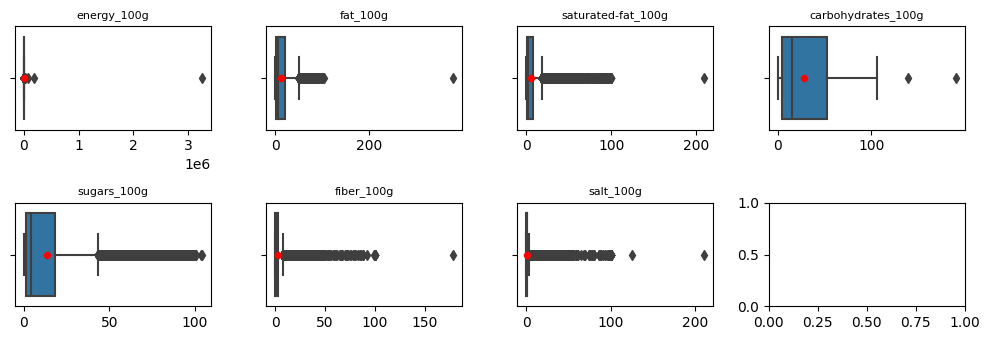

In [42]:
# Now let's represent these variables with a boxplot

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (10,3.5)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for each column
_, axs = plt.subplots(2, 4)
for i in range(len(check_outliers)):
  sns.boxplot(base_df_rmv, x=check_outliers[i], orient='h', ax=axs[i//4, i%4],
              showmeans=True, meanprops={'marker':'8',
                                         'markerfacecolor':'red',
                                         'markeredgecolor':'red',
                                         'markersize':'5'})
  # Remove x axis name
  axs[i//4, i%4].set(xlabel='')
  # Set the column name as title
  axs[i//4, i%4].set_title(check_outliers[i], fontsize=8)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

I will now examine the outliers one by one, because there could be a different reason for each column.

In case there is a "generic" explanation (define upper/lower boundaries and set the outliers to np.nan for instance), a function to apply might be considered for automation.

In [43]:
# Start by making a copy of the df
outliers_df = base_df_rmv.copy()

#### Outliers for energy

In [44]:
# Let's start by examining the outlier for the energy.
# 1000 should be a high value already:
col_ = 'energy_100g'

len(outliers_df[outliers_df[col_]>=1_000])
#outliers_df[outliers_df[col_]>=1_000].sort_values(by=[col_], ascending=False)

31424

That's a lot of rows, almost 50% of the remaining data! Maybe there's more to it.

In [45]:
# This seems to be expressed in kj (that's my guess), so I will need to convert
# it in kcal. Let's start with this:

# Define the coef. for conversion:
coef_ = 4.184

# Convert and round to 2 decimals
outliers_df['energy_kcal_100g'] = round(outliers_df[col_]/coef_, 2)

In [46]:
# Drop the old column
outliers_df.drop(columns=col_, inplace=True)
outliers_df.head()

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,fruits-veg-missing,energy_kcal_100g
0,Lion Peanut x2,e,unknown,unknown,20.0,12.5,70.0,57.5,2.5,2.5,0.10,0.04,0.0,22.0,1,450.05
1,Mini Confettis,d,NaN,NaN,NaN,0.8,NaN,87.7,0.9,0.6,0.01,0.00,0.0,14.0,1,418.98
2,Praliné Amande Et Noisette,d,NaN,NaN,NaN,2.9,NaN,50.3,3.9,9.5,0.00,0.00,0.0,14.0,1,575.05
3,"Pepsi, Nouveau goût !",e,Beverages,Sweetened beverages,0.0,0.0,10.4,10.4,0.0,0.0,0.03,0.01,0.0,13.0,1,42.30
4,Tarte Poireaux Et Lardons,d,NaN,NaN,NaN,11.0,NaN,1.0,1.4,7.5,0.80,0.31,0.0,15.0,1,257.89


In [47]:
# Let's have a new look at it
col_ = 'energy_kcal_100g'

len(outliers_df[outliers_df[col_]>1_000])
#outliers_df[outliers_df[col_]>1_000].sort_values(by=[col_], ascending=False)

73

That's more reasonable.

In [60]:
# I could decide to remove the values and then try to impute,
# or I could delete the rows, which is what I go for:
outliers_df = outliers_df.loc[outliers_df[col_]<=1_000]
outliers_df.shape

(60344, 16)

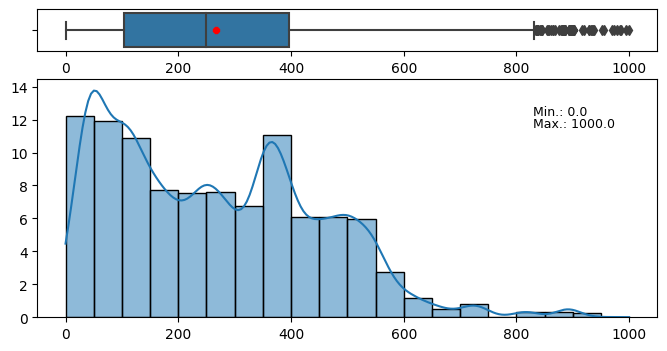

In [61]:
# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (8,4)

_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

#### Outliers for fat
* I am assuming a product like butter is 100% fat, so 100g is the upper boundary. This can be refined with domain knowledge.

In [62]:
# Let's start by examining the outliers for the fat
# 100 should be a high value:
col_ = 'fat_100g'

#len(outliers_df[outliers_df[col_]>100])
outliers_df[outliers_df[col_]>100].sort_values(by=[col_], ascending=False)

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,fruits-veg-missing,energy_kcal_100g
57393,Graine de couscous moyen,a,Cereals and potatoes,Cereals,105.0,0.3,70.0,2.5,NaN,12.0,0.01,0.0,0.0,-1.0,1,354.21


In [63]:
# This seems to be a mistake (considering the name). I set the value as np.nan:
outliers_df[col_].loc[outliers_df[col_]>100] = np.nan

<ipython-input-63-cee37c419a46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df[col_].loc[outliers_df[col_]>100] = np.nan


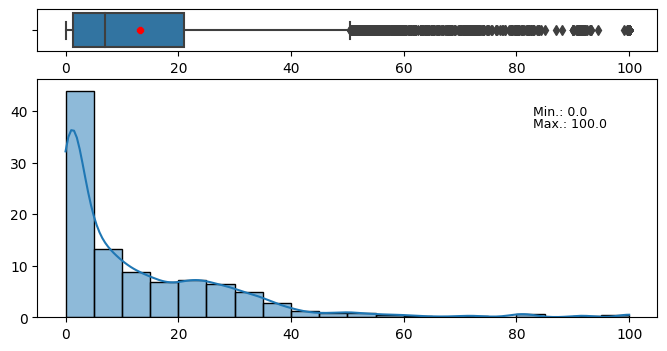

In [65]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

In [66]:
# Check how many outliers remain (above 50):
len(outliers_df[outliers_df[col_]>50])
#outliers_df[outliers_df[col_]>50].sort_values(by=[col_], ascending=False)

1490

That's not enough to create a new column, so I'll leave it as is.

#### Outliers for saturated fat
* Same assumption for the upper boundary

In [67]:
# Let's start by examining the outliers for the saturated fat.
# 100 should be a high value:
col_ = 'saturated-fat_100g'

len(outliers_df[outliers_df[col_]>100])
#outliers_df[outliers_df[col_]>100].sort_values(by=[col_], ascending=False)

0

Looks like the problematic rows disappeared (one of the deleted rows from the energy)!

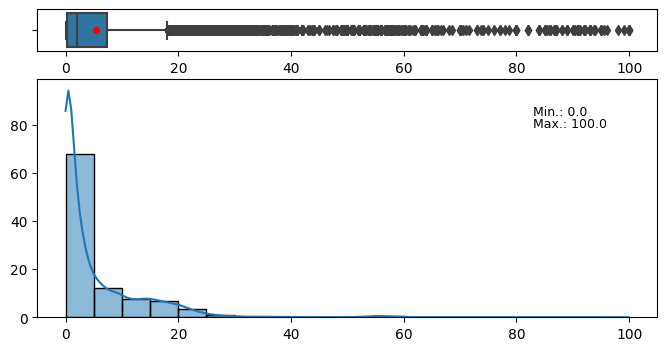

In [68]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

In [69]:
# Check how many outliers remain (above 17):
len(outliers_df[outliers_df[col_]>17])
#outliers_df[outliers_df[col_]>17].sort_values(by=[col_], ascending=False)

5181

That's actually quite a number of rows, so I'll go ahead and create a new column encoding the fact that these are outliers here, while setting the values to np.nan.

In [70]:
# First, create the new column
outliers_df['outlier_sat_fat'] = outliers_df[col_].gt(17).astype('int64')

# Then, fill the missing values
outliers_df[col_].loc[outliers_df[col_]>17] = np.nan

<ipython-input-70-f19f7b81690c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df['outlier_sat_fat'] = outliers_df[col_].gt(17).astype('int64')
<ipython-input-70-f19f7b81690c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df[col_].loc[outliers_df[col_]>17] = np.nan


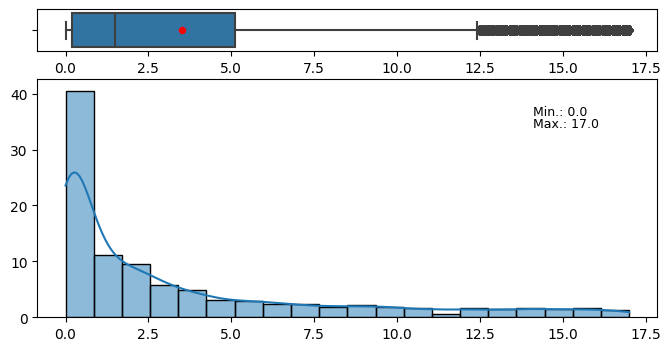

In [71]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

#### High values for carbohydrates
* Same assumption for the upper boundary

In [72]:
# Let's start by examining the high values for the carbohydrates.
# 100 should be a high value:
col_ = 'carbohydrates_100g'

#len(outliers_df[outliers_df[col_]>100])
outliers_df[outliers_df[col_]>100].sort_values(by=[col_], ascending=False)

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,fruits-veg-missing,energy_kcal_100g,outlier_sat_fat
60251,Banane sèche,c,Fruits and vegetables,Dried fruits,0.0,0.0,139.0,41.5,0.0,5.0,0.00,0.00,0.0,4.0,1,300.91,0
35138,Palets pur beurre,e,Sugary snacks,Biscuits and cakes,52.0,NaN,106.0,52.0,3.0,10.0,1.30,0.51,0.0,31.0,1,938.10,1
14380,Sirop d'Agave brun bio,d,unknown,unknown,0.0,0.0,104.0,104.0,0.0,0.0,0.14,0.06,0.0,15.0,1,420.65,0
48805,Sirop d agave pur,d,unknown,unknown,1.0,0.1,103.5,103.5,NaN,1.0,0.10,0.04,0.0,15.0,1,420.65,0
59771,NaN,d,unknown,unknown,0.0,0.0,100.8,100.8,0.0,0.0,0.43,0.17,0.0,16.0,1,409.66,0


Again, I could set the values to np.nan and then impute, or I could modify the value to 100 (upper boundary). For simplicity, and since this does not concern many rows, I delete them.

In [73]:
# Check the value of the index before running the cell!
outliers_df = outliers_df.drop(index=[14380, 35138, 48805, 59771, 60251])
outliers_df.shape

(60339, 17)

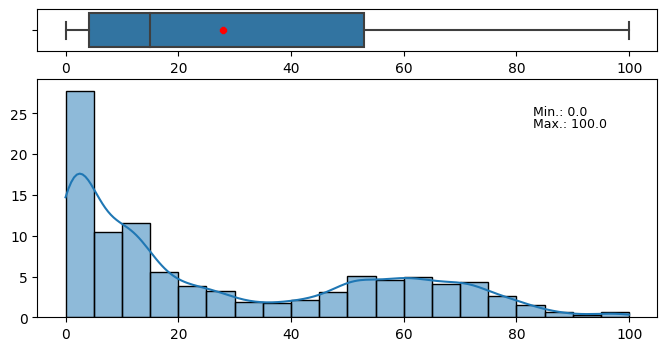

In [74]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

#### Abnormal values for sugars
* Same assumption for the upper boundary, also valid for the lower boundary (value can not be negative)

In [75]:
# Let's start by examining the negative values for the sugars.
# 0 should be the minimum:
col_ = 'sugars_100g'

#len(outliers_df[outliers_df[col_]<0])
outliers_df[outliers_df[col_]<0].sort_values(by=[col_], ascending=False)

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,fruits-veg-missing,energy_kcal_100g,outlier_sat_fat
10086,Caprice des dieux,d,Milk and dairy products,Cheese,30.0,NaN,0.8,-0.1,NaN,15.3,1.4,0.55,0.0,15.0,1,329.59,1


In [76]:
# This looks like a mistake. I'll set the value as 0:
outliers_df[col_].loc[outliers_df[col_]<0] = 0

<ipython-input-76-1f69793f9f44>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df[col_].loc[outliers_df[col_]<0] = 0


In [77]:
# Let's now examine the high values for the sugars.
# 100 should be a high value:
len(outliers_df[outliers_df[col_]>100])
#outliers_df[outliers_df[col_]>100].sort_values(by=[col_], ascending=False)

0

It looks like the rows got deleted already.

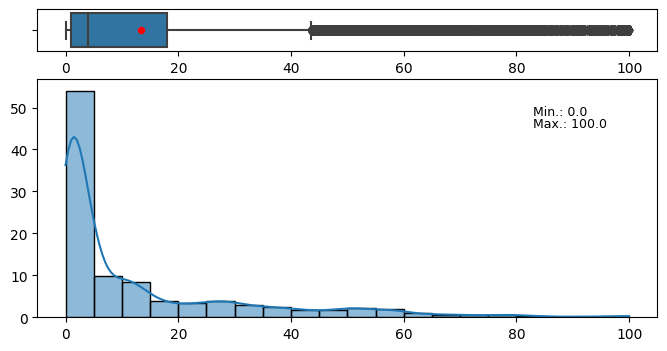

In [78]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

In [86]:
# Check how many outliers remain (above 42):
len(outliers_df[outliers_df[col_]>42])
#outliers_df[outliers_df[col_]>42].sort_values(by=[col_], ascending=False)

6210

Again, that's quite a number of rows, so I'll go ahead and create a new column encoding the fact that these are outliers here, while setting the values to np.nan.

In [87]:
# First, create the new column
outliers_df['outlier_sugars'] = outliers_df[col_].gt(42).astype('int64')

# Then, fill the missing values
outliers_df[col_].loc[outliers_df[col_]>42] = np.nan

<ipython-input-87-c3c9730496ce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df[col_].loc[outliers_df[col_]>42] = np.nan


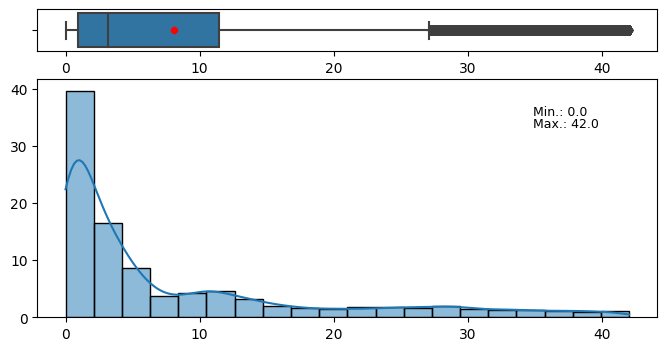

In [88]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

#### Outliers for fiber
* Same assumption for the upper boundary

In [89]:
# Let's start by examining the outliers for the fiber.
# 100 should be a high value:
col_ = 'fiber_100g'

#len(outliers_df[outliers_df[col_]>100])
outliers_df[outliers_df[col_]>100].sort_values(by=[col_], ascending=False)

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,fruits-veg-missing,energy_kcal_100g,outlier_sat_fat,outlier_sugars
55826,Milka Schmunzelhase Alpenmilch 175G,e,unknown,unknown,29.0,NaN,59.0,NaN,178.0,6.3,0.37,0.15,0.0,22.0,0,530.11,1,1


According to the Product name, I'm guessing the nutritional values here are entered for 175g. I could divide the values of the row by 1.75, but since I'm not 100% sure that all the values are impacted I delete the row.

In [90]:
# Check the value of the index before running the cell!
outliers_df = outliers_df.drop(index=[55826])
outliers_df.shape

(60338, 18)

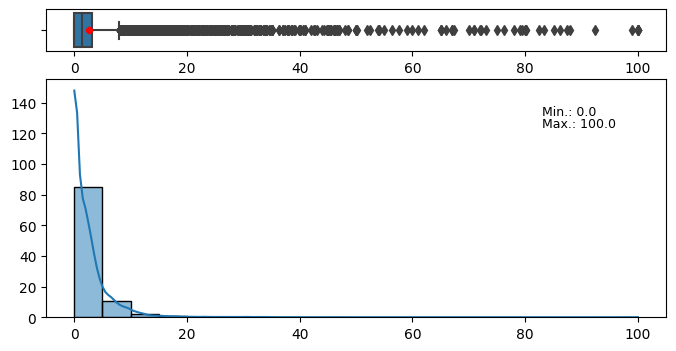

In [91]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

In [93]:
# Check how many outliers remain (above 6):
len(outliers_df[outliers_df[col_]>6])
#outliers_df[outliers_df[col_]>6].sort_values(by=[col_], ascending=False)

4801

Again, that's quite a number of rows, so I'll go ahead and create a new column encoding the fact that these are outliers here, while setting the values to np.nan.

In [94]:
# First, create the new column
outliers_df['outlier_fiber'] = outliers_df[col_].gt(6).astype('int64')

# Then, fill the missing values
outliers_df[col_].loc[outliers_df[col_]>6] = np.nan

<ipython-input-94-5a9be6028980>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df[col_].loc[outliers_df[col_]>6] = np.nan


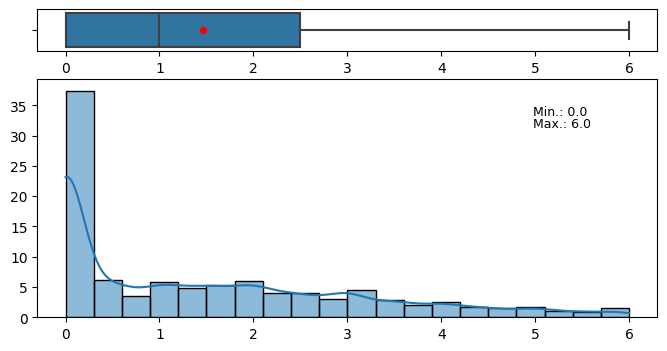

In [95]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

#### Outliers for salt
* Same assumption for the upper boundary

In [96]:
# Let's start by examining the outliers for the salt.
# 100 should be a high value:
col_ = 'salt_100g'

#len(outliers_df[outliers_df[col_]>100])
outliers_df[outliers_df[col_]>100].sort_values(by=[col_], ascending=False)

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,fruits-veg-missing,energy_kcal_100g,outlier_sat_fat,outlier_sugars,outlier_fiber
33797,Keeny Bio,e,Sugary snacks,Biscuits and cakes,23.0,3.33,47.8,26.7,0.74,6.3,211.0,83.00,0.0,22.0,1,411.09,0,0,0
34350,Sel de Guérande Label Rouge,c,unknown,unknown,0.0,0.00,0.0,0.0,0.00,0.0,125.0,49.21,0.0,10.0,1,0.00,0,0,0


The values seem to be indicated for more than 100g. I just delete the rows for simplicity.

In [97]:
# Check the value of the index before running the cell!
outliers_df = outliers_df.drop(index=[33797, 34350])
outliers_df.shape

(60336, 19)

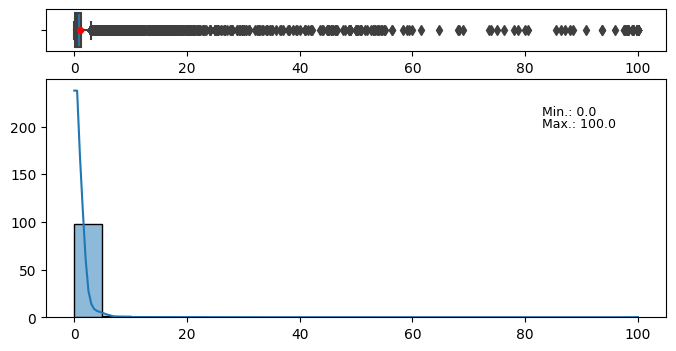

In [98]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

In [99]:
# Check how many outliers remain (above 2):
len(outliers_df[outliers_df[col_]>2])
#outliers_df[outliers_df[col_]>2].sort_values(by=[col_], ascending=False)

5565

Again, that's quite a number of rows, so I'll go ahead and create a new column encoding the fact that these are outliers here, while setting the values to np.nan.

In [100]:
# First, create the new column
outliers_df['outlier_salt'] = outliers_df[col_].gt(2).astype('int64')

# Then, fill the missing values
outliers_df[col_].loc[outliers_df[col_]>2] = np.nan

<ipython-input-100-95a517c6d0bd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df[col_].loc[outliers_df[col_]>2] = np.nan


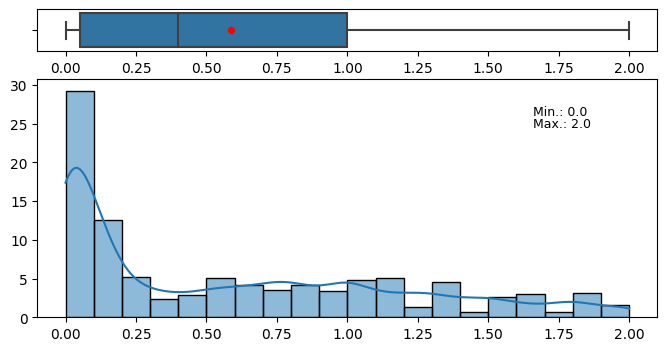

In [101]:
_, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': (.15, .85)})
# Boxplot 1st row
axs[0] = sns.boxplot(outliers_df, x=col_, orient='h', ax=axs[0],
                     showmeans=True, meanprops={'marker':'8',
                                                'markerfacecolor':'red',
                                                'markeredgecolor':'red',
                                                'markersize':'5'})
# Remove x axis name
axs[0].set(xlabel='')
# Histogram on 2nd row
axs[1] = sns.histplot(outliers_df, x=col_, stat='percent', bins=20, kde=True)
# Add min and max
axs[1].text(0.8, 0.85, 'Min.: {}'.format(outliers_df[col_].min()),
            fontsize=9, transform=axs[1].transAxes)
axs[1].text(0.8, 0.8, 'Max.: {}'.format(outliers_df[col_].max()),
            fontsize=9, transform=axs[1].transAxes)
# Remove x and y axis names
axs[1].set(xlabel='', ylabel='')
# Adjust spacing between (sub)plots
#plt.tight_layout()
plt.show()

### 3.1.2. Qualitative variables

In [102]:
# Let's reset the index, and make a copy
outliers_df.reset_index(drop=True)
outliers_df2 = outliers_df.copy()

In [104]:
outliers_df2.columns

Index(['product_name', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2',
       'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'fruits-vegetables-nuts_100g', 'nutrition-score-fr_100g',
       'fruits-veg-missing', 'energy_kcal_100g', 'outlier_sat_fat',
       'outlier_sugars', 'outlier_fiber', 'outlier_salt'],
      dtype='object')

In [105]:
# Define the list of columns
quant_cols = ['nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2']

# There are too many modalities for the product_name,
# I will not work on the column.

#### Nutrition grade
* As it is related to the Nutri Score, the values should only be A, B, C, D or E

In [106]:
# Check the values in the column
col_ = 'nutrition_grade_fr'

outliers_df2[col_].unique()

array(['e', 'd', 'c', 'a', 'b'], dtype=object)

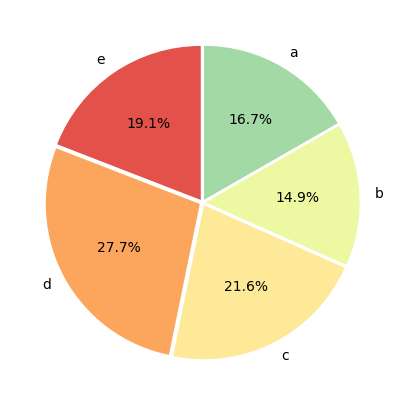

In [107]:
# Plot the repartition by group

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (5,5)

# Define the groups, plotted counterclockwise
nutri_groups = ['e', 'd', 'c', 'b', 'a']
# Define the spacing from the center
explode = [.02, .02, .02, .02, .02]
# Define the color palette
colors = sns.color_palette("Spectral")

# Create the plot
plt.pie(outliers_df2[col_].value_counts(normalize=True).reindex(nutri_groups),
        explode=explode, labels=nutri_groups, colors=colors, startangle=90,
        autopct='%1.1f%%')
plt.show()

# List of colors for subplots:
# https://seaborn.pydata.org/tutorial/color_palettes.html
# https://seaborn.pydata.org/generated/seaborn.color_palette.html

#### PNNS (Programme National Nutrition Sante)
* Related to a French national program. [Link to the 2019-2023 official sheet.](https://sante.gouv.fr/IMG/pdf/pnns4_2019-2023.pdf)
* Identifies categories of food to:
  * __Increase:__ dried vegetables, fresh fruits and vegetables, nuts
  * __Move towards:__ whole wheat bread, fishes, colza/nut/olive oil, dairy products,
  * __Reduce:__ cold cuts, too sweet/fat/salty products, alcohol, red meat.

In [108]:
# Check the values in the column pnns_1:
col_ = 'pnns_groups_1'

outliers_df2[col_].unique()

array(['unknown', nan, 'Beverages', 'Sugary snacks', 'Composite foods',
       'Fruits and vegetables', 'Milk and dairy products',
       'Fat and sauces', 'Salty snacks', 'Cereals and potatoes',
       'Fish Meat Eggs', 'fruits-and-vegetables', 'sugary-snacks',
       'cereals-and-potatoes'], dtype=object)

From this:
* There is an 'unknown' modality => the missing values can be filled with this
* Some modalitites appear duplicate:
  * 'Sugary snacks' and 'sugary-snacks'
  * 'Fruits and vegetables' and 'fruits-and-vegetables'
  * 'Cereals and potatoes' and 'cereals-and-potatoes'

In [109]:
# Let's fill the missing values, with 'unknown'
outliers_df2['pnns_groups_1'] = outliers_df2['pnns_groups_1'].fillna('unknown')

In [110]:
# Regroup the modalities:

# Create the wanted mapping:
new_pnns_1 = {'Beverages':['Beverages'],
              'Cereals and potatoes':['Cereals and potatoes',
                                      'cereals-and-potatoes'],
              'Composite foods':['Composite foods'],
              'Fat and sauces':['Fat and sauces'],
              'Fish Meat Eggs':['Fish Meat Eggs'],
              'Fruits and vegetables':['Fruits and vegetables',
                                       'fruits-and-vegetables'],
              'Milk and dairy products':['Milk and dairy products'],
              'Salty snacks':['Salty snacks'],
              'Sugary snacks':['Sugary snacks', 'sugary-snacks'],
              'UNK':['unknown']
              }

# Reverse it for use:
map_pnns_1 = {k: oldk for oldk, oldv in new_pnns_1.items() for k in oldv}

# Apply it
outliers_df2['pnns_groups_1'] = outliers_df2['pnns_groups_1'].map(map_pnns_1)

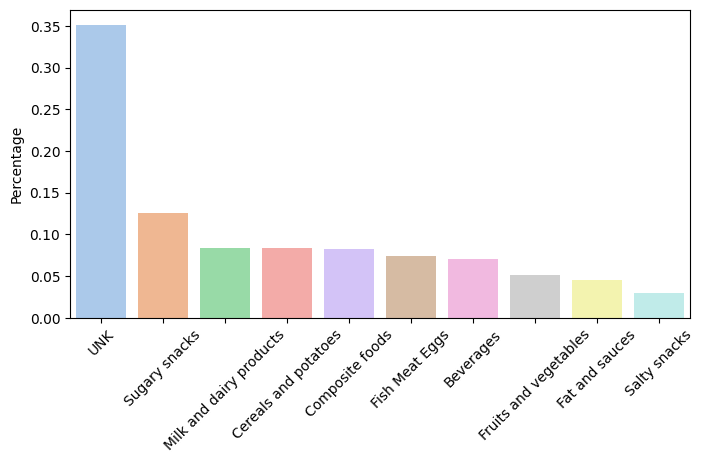

In [111]:
# Plot the repartition by group

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (8,4)

# Define the color palette
colors = sns.color_palette("pastel")

# Create the plot
ax = sns.barplot(data=outliers_df2,
                 x=outliers_df2[col_].value_counts(normalize=True).index,
                 y=outliers_df2[col_].value_counts(normalize=True),
                 palette=colors)
ax.set(ylabel='Percentage')
plt.xticks(rotation=45)
plt.show()

In [112]:
# Check the values in the column pnns_2:
col_ = 'pnns_groups_2'

outliers_df2[col_].unique()

array(['unknown', nan, 'Sweetened beverages', 'Biscuits and cakes',
       'One-dish meals', 'Soups', 'Non-sugared beverages', 'Cheese',
       'Sweets', 'Sandwich', 'Dressings and sauces', 'Appetizers', 'Nuts',
       'Dried fruits', 'Breakfast cereals', 'Pizza pies and quiche',
       'Fruits', 'Fruit juices', 'Cereals', 'Vegetables', 'Bread',
       'Chocolate products', 'Processed meat', 'Legumes', 'vegetables',
       'Ice cream', 'Fish and seafood', 'pastries', 'Milk and yogurt',
       'Dairy desserts', 'Meat', 'Fats',
       'Artificially sweetened beverages', 'Fruit nectars', 'Potatoes',
       'Alcoholic beverages', 'Salty and fatty products', 'Tripe dishes',
       'Eggs', 'fruits', 'cereals'], dtype=object)

From this:
* There is an 'unknown' modality => the missing values can be filled with this
* Some modalitites appear duplicate:
  * 'Vegetables' and 'vegetables'
  * 'Fruits' and 'fruits'
  * 'Cereals' and 'cereals'

In [113]:
# Let's fill the missing values, with 'unknown'
outliers_df2['pnns_groups_2'] = outliers_df2['pnns_groups_2'].fillna('unknown')

In [114]:
# Regroup the modalities:

# Create the wanted mapping:
new_pnns_2 = {'Alcoholic beverages':['Alcoholic beverages'],
              'Appetizers':['Appetizers'],
              'Artificially sweetened beverages':['Artificially sweetened beverages'],
              'Biscuits and cakes':['Biscuits and cakes'],
              'Bread':['Bread'],
              'Breakfast cereals':['Breakfast cereals'],
              'Cereals':['Cereals',
                         'cereals'],
              'Cheese':['Cheese'],
              'Chocolate products':['Chocolate products'],
              'Dairy desserts':['Dairy desserts'],
              'Dressings and sauces':['Dressings and sauces'],
              'Dried fruits':['Dried fruits'],
              'Eggs':['Eggs'],
              'Fats':['Fats'],
              'Fish and seafood':['Fish and seafood'],
              'Fruit juices':['Fruit juices'],
              'Fruit nectars':['Fruit nectars'],
              'Fruits':['Fruits',
                        'fruits'],
              'Ice cream':['Ice cream'],
              'Meat':['Meat'],
              'Milk and yogurt':['Milk and yogurt'],
              'Non-sugared beverages':['Non-sugared beverages'],
              'Nuts':['Nuts'],
              'One-dish meals':['One-dish meals'],
              'Pastries':['pastries'],
              'Pizza pies and quiche':['Pizza pies and quiche'],
              'Potatoes':['Potatoes'],
              'Processed meat':['Processed meat'],
              'Salty and fatty products':['Salty and fatty products'],
              'Sandwich':['Sandwich'],
              'Soups':['Soups'],
              'Sweetened beverages':['Sweetened beverages'],
              'Sweets':['Sweets'],
              'Tripe dishes':['Tripe dishes'],
              'UNK':['unknown'],
              'Vegetables':['Vegetables',
                            'Legumes',
                            'vegetables']
              }

# Reverse it for use:
map_pnns_2 = {k: oldk for oldk, oldv in new_pnns_2.items() for k in oldv}

# Apply it
outliers_df2['pnns_groups_2'] = outliers_df2['pnns_groups_2'].map(map_pnns_2)

## 3.2. Correlation

In [115]:
# Let's make a copy
cor_df = outliers_df2.copy()

In [116]:
# Check the dtypes to include: here the float64 and int64
cor_df.dtypes

product_name                    object
nutrition_grade_fr              object
pnns_groups_1                   object
pnns_groups_2                   object
fat_100g                       float64
saturated-fat_100g             float64
carbohydrates_100g             float64
sugars_100g                    float64
fiber_100g                     float64
proteins_100g                  float64
salt_100g                      float64
sodium_100g                    float64
fruits-vegetables-nuts_100g    float64
nutrition-score-fr_100g        float64
fruits-veg-missing               int64
energy_kcal_100g               float64
outlier_sat_fat                  int64
outlier_sugars                   int64
outlier_fiber                    int64
outlier_salt                     int64
dtype: object

In [117]:
num_df = cor_df.select_dtypes(include=['float64', 'int64'])
num_df.shape

(60336, 16)

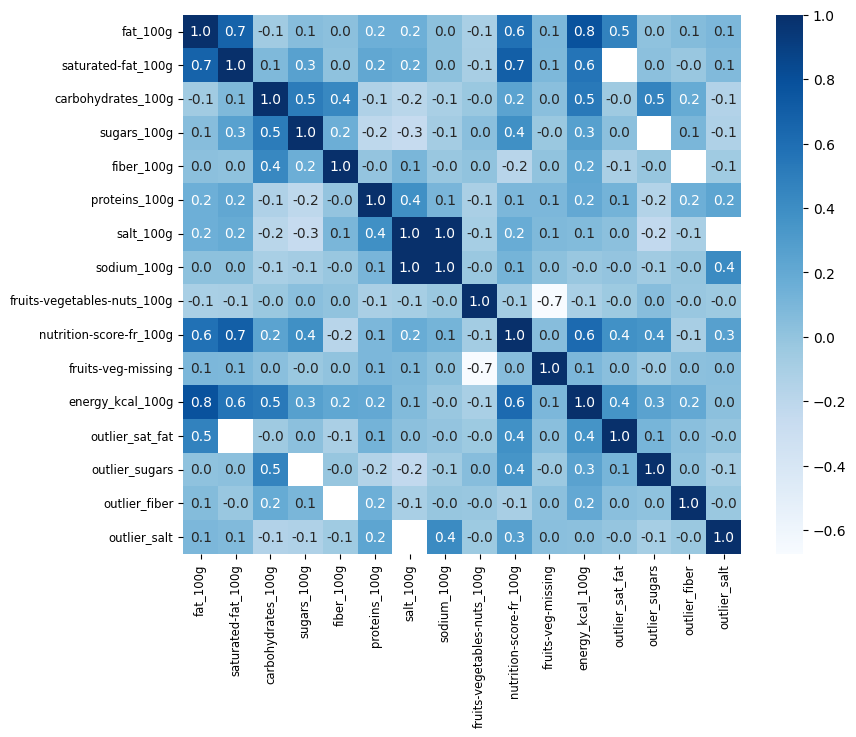

In [121]:
# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (9,7)

# Create the plot
ax = sns.heatmap(num_df.corr(), cmap='Blues', annot=True, fmt='.1f')
ax.tick_params(labelsize='small')
plt.show()

From this, it appears that some variables highly influence others (vs energy or even vs nutriscore, which needs to be explored).

Also, we see that salt and sodium carry the same information, so the emptiest one can be dropped.

In [122]:
# Let's remove the sodium
cor_df = cor_df.drop(columns='sodium_100g')

## 3.3. Missing values

In [123]:
# Let's make a copy
mis_val_df = cor_df.copy()

### Qualitative variables
* The blanks can be filled with something like 'UNK', unless there already is a modality encoding the missingness

In [125]:
mis_val_df.columns

Index(['product_name', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2',
       'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'fiber_100g', 'proteins_100g', 'salt_100g',
       'fruits-vegetables-nuts_100g', 'nutrition-score-fr_100g',
       'fruits-veg-missing', 'energy_kcal_100g', 'outlier_sat_fat',
       'outlier_sugars', 'outlier_fiber', 'outlier_salt'],
      dtype='object')

In [126]:
# Check if there are missing values
mis_val_df['product_name'].isna().sum()

336

In [127]:
# Fill with 'UNK
mis_val_df['product_name'].fillna('UNK', inplace=True)

In [128]:
# Check if there are missing values
mis_val_df['nutrition_grade_fr'].isna().sum()

0

### Quantitative variables
* There are different ways of 'filling the blanks', like imputing the mean (or median) or using an imputer like IterativeImputer, KNNImputer, etc.
* I'll go with the KNNImputer here.

In [129]:
# Define the imputer. I keep the default parameters (n=5):
imputer = KNNImputer()

In [131]:
# Select the subset to be imputed
imputed = mis_val_df.select_dtypes(include=['float64', 'int64'])

In [132]:
# Train on the numerical columns, and transform (~3/4 mins)
filling = imputer.fit_transform(imputed)

In [139]:
# Replace the newly imputed values
mis_val_df.iloc[:, 4:] = filling

<ipython-input-139-5ddcaabd7bd8>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  mis_val_df.iloc[:, 4:] = filling


In [140]:
# Check that no missing value remains
mis_val_df.isnull().sum()

product_name                   0
nutrition_grade_fr             0
pnns_groups_1                  0
pnns_groups_2                  0
fat_100g                       0
saturated-fat_100g             0
carbohydrates_100g             0
sugars_100g                    0
fiber_100g                     0
proteins_100g                  0
salt_100g                      0
fruits-vegetables-nuts_100g    0
nutrition-score-fr_100g        0
fruits-veg-missing             0
energy_kcal_100g               0
outlier_sat_fat                0
outlier_sugars                 0
outlier_fiber                  0
outlier_salt                   0
dtype: int64

Let's also confirm visually that the profiles remain similar.

In [150]:
# First, select the subset to plot
subset_ = mis_val_df.iloc[:, 4:15]

In [152]:
# Define the list of columns
quant_cols = subset_.columns

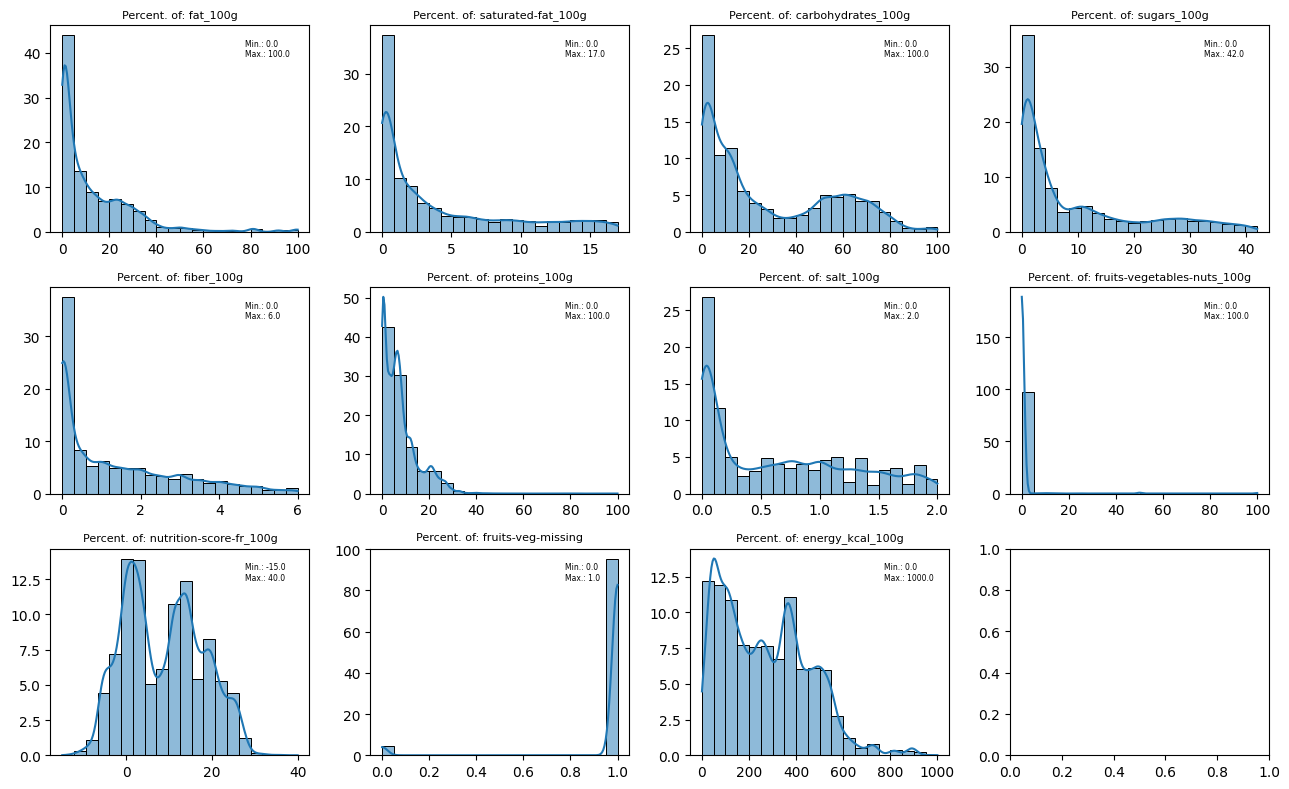

In [153]:
# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (13,8)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for each column
_, axs = plt.subplots(3, 4)
for i in range(len(quant_cols)):
  sns.histplot(subset_, x=quant_cols[i], stat='percent', bins=20, kde=True,
               ax=axs[i//4, i%4])
  # Remove x and y axis names
  axs[i//4, i%4].set(xlabel='', ylabel='')
  # Set the column name as title
  axs[i//4, i%4].set_title('Percent. of: {}'.format(quant_cols[i]), fontsize=8)
  # Add min and max within the subplots
  axs[i//4, i%4].text(0.75, 0.9,
                      'Min.: {}'.format(subset_[quant_cols[i]].min()),
                      fontsize=5.5, transform=axs[i//4, i%4].transAxes)
  axs[i//4, i%4].text(0.75, 0.85,
                      'Max.: {}'.format(subset_[quant_cols[i]].max()),
                      fontsize=5.5, transform=axs[i//4, i%4].transAxes)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

# 4. File export

In [154]:
# Start by making a copy
exported = mis_val_df.copy()

In [156]:
# Let's start by rounding the imputed columns to 2 decimals
exported = round(exported, 2)

In [157]:
exported.head()

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,fruits-veg-missing,energy_kcal_100g,outlier_sat_fat,outlier_sugars,outlier_fiber,outlier_salt
0,Lion Peanut x2,e,UNK,UNK,20.00,12.5,70.00,14.16,2.5,2.5,0.10,0.0,22.0,1.0,450.05,0.0,1.0,0.0,0.0
1,Mini Confettis,d,UNK,UNK,12.26,0.8,73.28,16.46,0.9,0.6,0.01,0.0,14.0,1.0,418.98,0.0,1.0,0.0,0.0
2,Praliné Amande Et Noisette,d,UNK,UNK,46.32,2.9,23.75,17.51,3.9,9.5,0.00,0.0,14.0,1.0,575.05,0.0,1.0,0.0,0.0
3,"Pepsi, Nouveau goût !",e,Beverages,Sweetened beverages,0.00,0.0,10.40,10.40,0.0,0.0,0.03,0.0,13.0,1.0,42.30,0.0,0.0,0.0,0.0
4,Tarte Poireaux Et Lardons,d,UNK,UNK,17.42,11.0,17.30,1.00,1.4,7.5,0.80,0.0,15.0,1.0,257.89,0.0,0.0,0.0,0.0


In [158]:
# Let's also re-order the columns
exported = exported.loc[:, ['product_name', 'energy_kcal_100g', 'fat_100g',
                            'saturated-fat_100g', 'outlier_sat_fat',
                            'carbohydrates_100g', 'sugars_100g',
                            'outlier_sugars', 'fiber_100g', 'outlier_fiber',
                            'proteins_100g', 'salt_100g', 'outlier_salt',
                            'fruits-vegetables-nuts_100g', 'fruits-veg-missing',
                            'nutrition-score-fr_100g', 'nutrition_grade_fr',
                            'pnns_groups_1', 'pnns_groups_2']]
exported.shape

(60336, 19)

In [159]:
# Finally, generate a csv file to be used for the next part
exported.to_csv("food_data_reworked.csv", sep='\t', index=False)

Next step is to upload the file to GitHub, to be accessed easily.